In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [9]:
sv_df = pd.read_csv("/home/tianhao/browser_pilot/server_v2_merged_20250423_223115.csv")
pr_df = pd.read_csv("/home/tianhao/browser_pilot/async_merged_20250423_120327.csv")

In [10]:
worker_input_queue_time = sv_df["worker_input_queue_time"]
worker_output_queue_time = sv_df["worker_output_queue_time"]
app_to_engine = sv_df["app_to_engine"]
engine_to_app = sv_df["engine_to_app"]
send_communication_time = sv_df["send_communication_time"]
recv_communication_time = sv_df["recv_communication_time"]
worker_process_time = sv_df["worker_process_time"]
total_time = sv_df["total_time"]


worker_input_queue_time_percentage = (
    worker_input_queue_time.sum() / total_time.sum() * 100
)
worker_output_queue_time_percentage = (
    worker_output_queue_time.sum() / total_time.sum() * 100
)
app_to_engine_percentage = app_to_engine.sum() / total_time.sum() * 100
engine_to_app_percentage = engine_to_app.sum() / total_time.sum() * 100
send_communication_time_percentage = (
    send_communication_time.sum() / total_time.sum() * 100
)
recv_communication_time_percentage = (
    recv_communication_time.sum() / total_time.sum() * 100
)
worker_process_time_percentage = worker_process_time.sum() / total_time.sum() * 100

print(f"App to engine percentage: {app_to_engine_percentage:.2f}%")
print(f"Send communication time percentage: {send_communication_time_percentage:.2f}%")
print(f"Worker input queue time percentage: {worker_input_queue_time_percentage:.2f}%")
print(f"Worker process time percentage: {worker_process_time_percentage:.2f}%")
print(
    f"Worker output queue time percentage: {worker_output_queue_time_percentage:.2f}%"
)
print(f"Recv communication time percentage: {recv_communication_time_percentage:.2f}%")
print(f"Engine to app percentage: {engine_to_app_percentage:.2f}%")

print(
    "Total time mean (including non-worker process time):", sv_df["total_time"].mean()
)
print("Worker process time mean:", sv_df["worker_process_time"].mean())

App to engine percentage: 3.92%
Send communication time percentage: 0.15%
Worker input queue time percentage: 0.05%
Worker process time percentage: 91.46%
Worker output queue time percentage: 0.00%
Recv communication time percentage: 3.74%
Engine to app percentage: 0.36%
Total time mean (including non-worker process time): 2.2928817390580662
Worker process time mean: 2.097178173006978


In [11]:
pr_df["duration"].mean()

np.float64(1.7925557819427922)

### Print interval

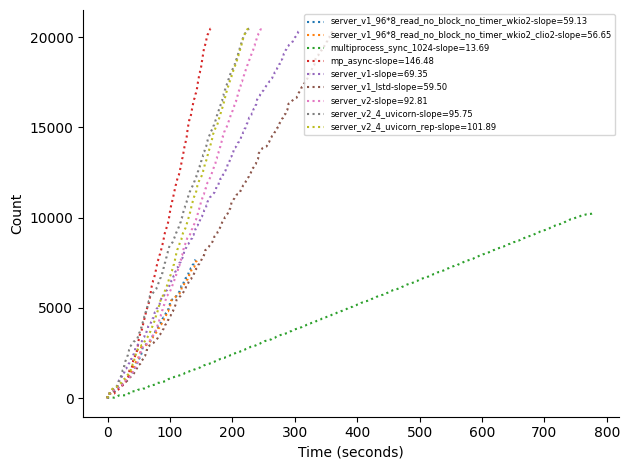

In [12]:
def plot_linear_scan(path, name):
    df = pd.read_csv(path)

    if "duration" not in df.columns:
        smallest_start = df["app_init"].min()
        normalized_start_time = df["app_init"] - smallest_start
        start_times = normalized_start_time.tolist()
        end_times = (df["app_recv"] - smallest_start).tolist()
    else:
        smallest_start = df["start_time"].min()
        normalized_start_time = df["start_time"] - smallest_start

        start_times = normalized_start_time.tolist()
        end_times = (normalized_start_time + df["duration"]).tolist()

    start_times = sorted(start_times)
    end_times = sorted(end_times)
    max_time = max(max(start_times), max(end_times))

    # Prepare events for concurrent curve
    times = [(start, -1) for start in start_times]
    times.extend([(end, 1) for end in end_times])
    times = sorted(times)

    scan_time = 0.0
    step_size = 0.1
    current_prefix = 0
    event_idx = 0
    num_events = len(times)
    num_starts = len(start_times)
    num_ends = len(end_times)
    start_idx = 0
    end_idx = 0

    result = []
    cumulative_starts = []
    cumulative_ends = []

    while scan_time <= max_time:
        # Concurrent curve
        while event_idx < num_events and times[event_idx][0] <= scan_time:
            current_prefix -= times[event_idx][1]
            event_idx += 1
        result.append((scan_time, current_prefix))

        # Cumulative starts
        while start_idx < num_starts and start_times[start_idx] <= scan_time:
            start_idx += 1
        cumulative_starts.append((scan_time, start_idx))

        # Cumulative ends
        while end_idx < num_ends and end_times[end_idx] <= scan_time:
            end_idx += 1
        cumulative_ends.append((scan_time, end_idx))

        scan_time += step_size

    # Prepare DataFrame for seaborn
    df_plot = pd.DataFrame(
        {
            "time": [r[0] for r in result],
            "concurrent": [r[1] for r in result],
            "cumulative_start": [r[1] for r in cumulative_starts],
            "cumulative_end": [r[1] for r in cumulative_ends],
        }
    )

    # plt.figure(figsize=(12, 6))
    # sns.lineplot(data=df_plot, x="time", y="concurrent", label=f"{name} - Concurrent", linewidth=2)
    # sns.lineplot(data=df_plot, x="time", y="cumulative_start", label=f"{name} - Cumulative Starts", linestyle="--")
    reg = LinearRegression().fit(
        df_plot["time"].values.reshape(-1, 1)[200:],
        df_plot["cumulative_end"].values[200:],
    )
    slope = reg.coef_[0]
    # intercept = reg.intercept_
    sns.lineplot(
        data=df_plot,
        x="time",
        y="cumulative_end",
        label=f"{name}-slope={slope:.2f}",
        linestyle=":",
    )
    # plt.title("Concurrent, Cumulative Start, and Cumulative End Curves")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Count")
    plt.legend(prop={"size": 6})
    sns.despine()
    plt.tight_layout()


plt.figure()

# plot_linear_scan("/home/tianhao/browser_pilot/test_server_v1_merged_20250422_235536.csv", "server_v1_512*8_fake_obs")
# plot_linear_scan("/home/tianhao/browser_pilot/test_server_v1_merged_20250423_001349.csv", "server_v1_512*8_real")
# plot_linear_scan("/home/tianhao/browser_pilot/test_server_v1_merged_20250423_004511.csv", "server_v1_512*8_real_block_recv")
# plot_linear_scan("/home/tianhao/browser_pilot/test_server_v1_merged_20250423_005520.csv", "server_v1_512*8_fake_block_recv")
# plot_linear_scan("/home/tianhao/browser_pilot/test_server_v1_merged_20250423_011155.csv", "server_v1_512*8_fake_no_block_no_timer")
plot_linear_scan(
    "/home/tianhao/browser_pilot/test_server_v1_merged_20250423_015449.csv",
    "server_v1_96*8_read_no_block_no_timer_wkio2",
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/test_server_v1_merged_20250423_020251.csv",
    "server_v1_96*8_read_no_block_no_timer_wkio2_clio2",
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/multiprocess_sync_merged_20250423_023202.csv",
    "multiprocess_sync_1024",
)
# plot_linear_scan("/home/tianhao/browser_pilot/multiprocess_async_playwright_merged_20250422_232800.csv", "multiprocess_async_playwright_1024*8")
# plot_linear_scan("/home/tianhao/browser_pilot/multiprocess_async_playwright_merged_20250423_013541.csv", "multiprocess_async_playwright_1024*8_rep")

plot_linear_scan(
    "/home/tianhao/browser_pilot/async_merged_20250423_120327.csv", "mp_async"
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/server_merged_20250423_121822.csv", "server_v1"
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/server_merged_20250423_125611.csv", "server_v1_lstd"
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/server_v2_merged_20250423_144635.csv", "server_v2"
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/server_v2_merged_20250423_160331.csv",
    "server_v2_4_uvicorn",
)
plot_linear_scan(
    "/home/tianhao/browser_pilot/server_v2_merged_20250423_223115.csv",
    "server_v2_4_uvicorn_rep",
)